Notes:
*   code to be added later to extraction in lvae colab
*   run lvae colab notebook first since fmri is processed and saved there
*   saving of ground truth images is also in lvae colab notebook





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ichiyan/brain-decoding.git

Cloning into 'brain-decoding'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 548 (delta 21), reused 26 (delta 9), pack-reused 497
Receiving objects: 100% (548/548), 513.73 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [3]:
cd /content/brain-decoding

/content/brain-decoding


In [4]:
!git pull

Already up to date.


## Install packages

In [ ]:
!pip install -U controlnet_aux==0.0.7

In [ ]:
!pip install transformers accelerate safetensors einops torchvision omegaconf torchtext ml-collections gdown webdataset braceexpand mpi4py

## Imports

In [8]:
cd /content/brain-decoding/scripts/latest

/content/brain-decoding/scripts/latest


In [9]:
import sys
# sys.path.append('vdvae')
sys.path.insert(1, '../../vdvae/')
import torch
import numpy as np
#from mpi4py import MPI
import socket
import subprocess
from hps import Hyperparams, parse_args_and_update_hparams, add_vae_arguments
from utils import (logger,
                   local_mpi_rank,
                   mpi_size,
                   maybe_download,
                   mpi_rank)
from data import mkdir_p
from contextlib import contextmanager
import torch.distributed as dist
#from apex.optimizers import FusedAdam as AdamW
from vae import VAE
from torch.nn.parallel.distributed import DistributedDataParallel
from train_helpers import restore_params
from image_utils import *
from model_utils import *
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pickle

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os
import requests
import math
import random
import json
import webdataset as wds
import braceexpand
import torch.nn.functional as F
from tqdm import tqdm

from controlnet_aux.midas import MidasDetector

# for debugging in colab
import pdb

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [10]:
subj_id = "02"
sub = 2
num_latents = 47
alpha = 100

# batch_size and test_batch_size must be 1 since midas_depth seems to only accept one image
batch_size = 1
test_batch_size = 1
local_rank = 0
num_devices = 1
num_workers = 1
seed = 0

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load data

In [12]:
print('Prepping train and validation dataloaders...')
num_train = 8859
num_val = 982

Prepping train and validation dataloaders...


In [13]:
print('Pulling NSD webdataset data...')

# urls should be local path
train_url = f"{{/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/train/train_subj{subj_id}_{{0..17}}.tar,/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/val/val_subj{subj_id}_0.tar}}"
val_url = f"/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/test/test_subj{subj_id}_{{0..1}}.tar"
meta_url = f"/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/metadata_subj{subj_id}.json"

# mindeye code
# train_url = f"../data/train_subj01_"+"{0..2}.tar"
# val_url = f"../data/val_subj01_0.tar"
# meta_url = f"../data/metadata_subj01.json"

Pulling NSD webdataset data...


In [14]:
def get_dataloaders(
    batch_size,
    image_var='images',
    num_devices=None,
    num_workers=None,
    train_url=None,
    val_url=None,
    meta_url=None,
    num_train=None,
    num_val=None,
    cache_dir="/tmp/wds-cache",
    seed=0,
    voxels_key="nsdgeneral.npy",
    val_batch_size=None,
    to_tuple=["voxels", "images", "trial"],
    local_rank=0,
    world_size=1,
    subj=1,
):
    print("Getting dataloaders...")
    assert image_var == 'images'

    def my_split_by_node(urls):
        return urls

    train_url = list(braceexpand.braceexpand(train_url))
    val_url = list(braceexpand.braceexpand(val_url))
    if not os.path.exists(train_url[0]):
        # we will default to downloading from huggingface urls if data_path does not exist
        print("downloading NSD from huggingface...")
        os.makedirs(cache_dir,exist_ok=True)

        # train_url, val_url, test_url = get_huggingface_urls("main",subj)
        train_url, test_url = get_huggingface_urls("main",subj)
        train_url = list(braceexpand.braceexpand(train_url))
        # val_url = list(braceexpand.braceexpand(val_url))
        test_url = list(braceexpand.braceexpand(test_url))

        from tqdm import tqdm
        for url in tqdm(train_url):
            destination = cache_dir + "/" + url.rsplit('/', 1)[-1]
            print(f"\nDownloading {url} to {destination}...")
            response = requests.get(url)
            response.raise_for_status()
            with open(destination, 'wb') as file:
                file.write(response.content)

        # for url in tqdm(val_url):
        #     destination = cache_dir + "/" + url.rsplit('/', 1)[-1]
        #     print(f"\nDownloading {url} to {destination}...")
        #     response = requests.get(url)
        #     response.raise_for_status()
        #     with open(destination, 'wb') as file:
        #         file.write(response.content)

        for url in tqdm(test_url):
            destination = cache_dir + "/" + url.rsplit('/', 1)[-1]
            print(f"\nDownloading {url} to {destination}...")
            response = requests.get(url)
            response.raise_for_status()
            with open(destination, 'wb') as file:
                file.write(response.content)

    if num_devices is None:
        num_devices = torch.cuda.device_count()

    if num_workers is None:
        num_workers = num_devices

    if num_train is None:
        metadata = json.load(open(meta_url))
        num_train = metadata['totals']['train']
    if num_val is None:
        metadata = json.load(open(meta_url))
        num_val = metadata['totals']['val']

    if val_batch_size is None:
        val_batch_size = batch_size

    global_batch_size = batch_size * num_devices
    num_batches = math.floor(num_train / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    if num_worker_batches == 0: num_worker_batches = 1

    print("\nnum_train",num_train)
    print("global_batch_size",global_batch_size)
    print("batch_size",batch_size)
    print("num_workers",num_workers)
    print("num_batches",num_batches)
    print("num_worker_batches", num_worker_batches)

    # train_url = train_url[local_rank:world_size]
    # train_data = wds.WebDataset(train_url, resampled=True, cache_dir=cache_dir, nodesplitter=my_split_by_node)\
    #     .shuffle(500, initial=500, rng=random.Random(42))\
    #     .decode("torch")\
    #     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    #     .to_tuple(*to_tuple)\
    #     .batched(batch_size, partial=True)\
    #     .with_epoch(num_worker_batches)

    train_data = wds.WebDataset(train_url, resampled=False, cache_dir=cache_dir, nodesplitter=my_split_by_node)\
        .decode("torch")\
        .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
        .to_tuple(*to_tuple)\
        .batched(batch_size, partial=False)

    train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, num_workers=1, shuffle=False)

    # Validation
    # should be deterministic, no shuffling!
    num_batches = math.floor(num_val / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    if num_worker_batches == 0: num_worker_batches = 1

    print("\nnum_val",num_val)
    print("val_num_batches",num_batches)
    print("val_batch_size",val_batch_size)

    # val_data = wds.WebDataset(val_url, resampled=False, cache_dir=cache_dir, nodesplitter=my_split_by_node)\
    #     .decode("torch")\
    #     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    #     .to_tuple(*to_tuple)\
    #     .batched(val_batch_size, partial=False)

    # val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, num_workers=1, shuffle=False)

    test_data = wds.WebDataset(test_url, resampled=False, cache_dir=cache_dir, nodesplitter=my_split_by_node)\
        .decode("torch")\
        .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
        .to_tuple(*to_tuple)\
        .batched(val_batch_size, partial=False)

    test_dl = torch.utils.data.DataLoader(test_data, batch_size=None, num_workers=1, shuffle=False)

    return train_dl, test_dl, num_train, num_val

In [15]:
def get_huggingface_urls(commit='main',subj=1):
    base_url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/"
    train_url = base_url + commit + f"/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar"
    # val_url = base_url + commit + f"/webdataset_avg_split/val/val_subj0{subj}_0.tar"
    test_url = base_url + commit + f"/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
    # return train_url, val_url, test_url
    return train_url, test_url

In [16]:
print(f"Fetching data for subject {sub}...")
train_dl, test_dl, num_train, num_test = get_dataloaders(
    batch_size,
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    # val_batch_size=max(16, batch_size),
    val_batch_size=test_batch_size,
    cache_dir='/tmp/wds-cache',
    seed=seed+local_rank,
    voxels_key='nsdgeneral.npy',
    local_rank=local_rank,
    num_train=num_train,
    num_val=num_val,
    subj=sub
)

Fetching data for subject 2...
Getting dataloaders...
downloading NSD from huggingface...


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:10<03:05, 10.90s/it]

 11%|█         | 2/18 [00:21<02:53, 10.84s/it]

 17%|█▋        | 3/18 [00:34<02:54, 11.65s/it]

 22%|██▏       | 4/18 [01:01<04:10, 17.91s/it]

 28%|██▊       | 5/18 [01:24<04:12, 19.46s/it]

 33%|███▎      | 6/18 [01:38<03:31, 17.62s/it]

 39%|███▉      | 7/18 [01:55<03:11, 17.41s/it]

 44%|████▍     | 8/18 [02:08<02:40, 16.07s/it]

 50%|█████     | 9/18 [02:22<02:19, 15.49s/it]

 56%|█████▌    | 10/18 [02:38<02:05, 15.63s/it]

 61%|██████    | 11/18 [02:51<01:44, 14.86s/it]

 67%|██████▋   | 12/18 [03:03<01:24, 14.00s/it]

 72%|███████▏  | 13/18 [03:14<01:05, 13.19s/it]

 78%|███████▊  | 14/18 [03:26<00:50, 12.60s/it]

 83%|████████▎ | 15/18 [03:37<00:36, 12.28s/it]

 89%|████████▉ | 16/18 [03:49<00:24, 12.06s/it]

 94%|█████████▍| 17/18 [04:00<00:11, 11.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.18s/it]

100%|██████████| 2/2 [00:22<00:00, 11.07s/it]


num_train 8859
global_batch_size 1
batch_size 1
num_workers 1
num_batches 8859
num_worker_batches 8859

num_val 982
val_num_batches 982
val_batch_size 1


## Load VDVAE

In [17]:
cp /content/drive/MyDrive/brain_decoding/data/vdvae/imagenet64-iter-1600000-log.jsonl /content/brain-decoding/vdvae/model/imagenet64-iter-1600000-log.jsonl

In [18]:
cp /content/drive/MyDrive/brain_decoding/data/vdvae/imagenet64-iter-1600000-model-ema.th /content/brain-decoding/vdvae/model/imagenet64-iter-1600000-model-ema.th

In [19]:
cp /content/drive/MyDrive/brain_decoding/data/vdvae/imagenet64-iter-1600000-model.th /content/brain-decoding/vdvae/model/imagenet64-iter-1600000-model.th

In [20]:
cp /content/drive/MyDrive/brain_decoding/data/vdvae/imagenet64-iter-1600000-opt.th /content/brain-decoding/vdvae/model/imagenet64-iter-1600000-opt.thz

In [21]:
cd /content/brain-decoding

/content/brain-decoding


In [22]:
H = {'image_size': 64, 'image_channels': 3,'seed': 0, 'port': 29500, 'save_dir': './saved_models/test', 'data_root': './', 'desc': 'test', 'hparam_sets': 'imagenet64', 'restore_path': 'imagenet64-iter-1600000-model.th', 'restore_ema_path': 'vdvae/model/imagenet64-iter-1600000-model-ema.th', 'restore_log_path': 'imagenet64-iter-1600000-log.jsonl', 'restore_optimizer_path': 'imagenet64-iter-1600000-opt.th', 'dataset': 'imagenet64', 'ema_rate': 0.999, 'enc_blocks': '64x11,64d2,32x20,32d2,16x9,16d2,8x8,8d2,4x7,4d4,1x5', 'dec_blocks': '1x2,4m1,4x3,8m4,8x7,16m8,16x15,32m16,32x31,64m32,64x12', 'zdim': 16, 'width': 512, 'custom_width_str': '', 'bottleneck_multiple': 0.25, 'no_bias_above': 64, 'scale_encblock': False, 'test_eval': True, 'warmup_iters': 100, 'num_mixtures': 10, 'grad_clip': 220.0, 'skip_threshold': 380.0, 'lr': 0.00015, 'lr_prior': 0.00015, 'wd': 0.01, 'wd_prior': 0.0, 'num_epochs': 10000, 'n_batch': 4, 'adam_beta1': 0.9, 'adam_beta2': 0.9, 'temperature': 1.0, 'iters_per_ckpt': 25000, 'iters_per_print': 1000, 'iters_per_save': 10000, 'iters_per_images': 10000, 'epochs_per_eval': 1, 'epochs_per_probe': None, 'epochs_per_eval_save': 1, 'num_images_visualize': 8, 'num_variables_visualize': 6, 'num_temperatures_visualize': 3, 'mpi_size': 1, 'local_rank': 0, 'rank': 0, 'logdir': './saved_models/test/log'}
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
H = dotdict(H)

H, preprocess_fn = set_up_data(H)

print('Models Loading...')
ema_vae = load_vaes(H)

RuntimeError: ignored

## Extract features

In [ ]:
midas_depth = MidasDetector.from_pretrained(
  "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large"
).to(device)

In [ ]:
keys = ["test", "train"]

dataloaders = {
    keys[0]: test_dl,
    keys[1]: train_dl,
}

# stimulus_images = {
#     keys[0]: [],
#     keys[1]: []
# }


depth_images = {
    keys[0]: [],
    keys[1]: []
}

latents = {
    keys[0]: [],
    keys[1]: []
}


In [27]:
for data in keys:
    print(f"Extracting features of {data} data...")
    # passing data one at a time
    for ndx, (_, image, _) in enumerate(tqdm(dataloaders[data])):

        image_512 = F.interpolate(image, (512, 512), mode='bilinear', align_corners=False, antialias=True)
        # stimulus_images[data].append(image_512) #(b,c,h,w)

        image_depth = midas_depth(transforms.ToPILImage()(image[0]), detect_resolution=425, image_resolution=64)

        print(type(image_depth), image_depth.shape)

        break

        image_depth = transforms.ToTensor()(image_depth).unsqueeze(0) #(b,c,h,w)
        depth_images[data].append(image_depth)

        data_input, target = preprocess_fn(image_depth.permute(0,2,3,1))

        with torch.no_grad():
            activations = ema_vae.encoder.forward(data_input)
            px_z, stats = ema_vae.decoder.forward(activations, get_latents=True)
            #recons = ema_vae.decoder.out_net.sample(px_z)
            batch_latent = []
            for i in range(num_latents):
                #test_latents[i].append(stats[i]['z'].cpu().numpy())
                batch_latent.append(stats[i]['z'].cpu().numpy().reshape(len(data_input),-1))

            latents[data].append(np.hstack(batch_latent))

Extracting features of test data...


982it [05:07,  3.19it/s]


Extracting features of train data...


8559it [44:53,  3.18it/s]


In [28]:
depth_images_backup = {
    keys[0]: depth_images[keys[0]],
    keys[1]: depth_images[keys[1]],
}

latents_backup = {
    keys[0]: latents[keys[0]],
    keys[1]: latents[keys[1]],
}

print(len(depth_images[keys[0]]), len(depth_images[keys[1]]))
print(len(latents[keys[0]]), len(latents[keys[1]]))

982 8559
982 8559


In [29]:
depth_images[keys[0]] = torch.stack(depth_images[keys[0]])
depth_images[keys[1]] = torch.stack(depth_images[keys[1]])

latents[keys[0]] = np.concatenate(latents[keys[0]])
latents[keys[1]] = np.concatenate(latents[keys[1]])

In [28]:
torch.save(depth_images[keys[0]], f"/content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{subj_id}/webdataset/depth_stim_test_sub{sub}.pt")
torch.save(depth_images[keys[1]], f"/content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{subj_id}/webdataset/depth_stim_train_sub{sub}.pt")


In [30]:
np.savez("/content/drive/MyDrive/brain_decoding/data/vdvae/subj{:02d}/nsd_vdvae_features_{}l_sub{}.npz".format(sub,num_latents,sub),train_latents=latents[keys[1]],test_latents=latents[keys[0]])

In [31]:
print(depth_images[keys[0]].shape, depth_images[keys[1]].shape)  #squeeze(1) => (b,c,h,w)
print(latents[keys[0]].shape, latents[keys[1]].shape)

AttributeError: ignored

## Regression

In [11]:
cd /content/brain-decoding

/content/brain-decoding


In [12]:
import sklearn.linear_model as skl
import pickle

In [35]:
# run if executing the cell below results into the error: A UTF-8 locale is required. Got ANSI_X3.4-1968

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
# vdvae latents
!cp /content/drive/MyDrive/brain_decoding/data/vdvae/subj{subj_id}/nsd_vdvae_features_{num_latents}l_sub{sub}.npz /content/brain-decoding/data/extracted_features/subj{subj_id}
# # fmri
!cp /content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{subj_id}/webdataset/nsd_fmriavg_nsdgeneral_sub{sub}.npz /content/brain-decoding/data/processed_data/subj{subj_id}

In [14]:
nsd_features = np.load('data/extracted_features/subj{:02d}/nsd_vdvae_features_{}l_sub{}.npz'.format(sub,num_latents,sub))
train_latents = nsd_features['train_latents']
test_latents = nsd_features['test_latents']
print(train_latents.shape, test_latents .shape)

(8559, 353312) (982, 353312)


In [15]:
fmri = np.load('data/processed_data/subj{:02d}/nsd_fmriavg_nsdgeneral_sub{}.npz'.format(sub,sub))
train_fmri = fmri['train_fmri']
test_fmri = fmri['test_fmri']
print(train_fmri.shape, test_fmri.shape)

(8559, 14278) (982, 14278)


In [16]:
## Preprocessing fMRI

train_fmri = train_fmri/300
test_fmri = test_fmri/300

norm_mean_train = np.mean(train_fmri, axis=0)
norm_scale_train = np.std(train_fmri, axis=0, ddof=1)
train_fmri = (train_fmri - norm_mean_train) / norm_scale_train
test_fmri = (test_fmri - norm_mean_train) / norm_scale_train

print(np.mean(train_fmri),np.std(train_fmri))
print(np.mean(test_fmri),np.std(test_fmri))

print(np.max(train_fmri),np.min(train_fmri))
print(np.max(test_fmri),np.min(test_fmri))

-3.1625003e-09 0.9999421
-0.02679766 0.995617
11.157454 -13.014394
11.769697 -13.347021


In [17]:
from sklearn.model_selection import RepeatedKFold

In [19]:
# if sub==1:
#     alpha=40
# elif sub==2:
#     alpha=50
# elif sub==5:
#     alpha=60
# elif sub==7:
#     alpha=60

alpha = 100

In [19]:
num_voxels, num_train, num_test = train_fmri.shape[1], len(train_fmri), len(test_fmri)

## latents Features Regression
print(f'Training latents Feature Regression - sub {sub} ...')

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# reg = skl.RidgeCV(alphas=np.arange(10000, 100000, 10000), cv=cv, scoring='neg_mean_absolute_error', fit_intercept=True)

reg = skl.Ridge(alpha=alpha*1000, max_iter=10000, fit_intercept=True)
reg.fit(train_fmri, train_latents)
pred_test_latent = reg.predict(test_fmri)
std_norm_test_latent = (pred_test_latent - np.mean(pred_test_latent,axis=0)) / np.std(pred_test_latent,axis=0)
pred_latents = std_norm_test_latent * np.std(train_latents,axis=0) + np.mean(train_latents,axis=0)
print(reg.score(test_fmri,test_latents))

# print(reg.score(test_fmri,test_latents), 'alpha: %f' % reg.alpha_)

np.save('/content/drive/MyDrive/brain_decoding/data/vdvae/subj{:02d}/nsd_vdvae_nsdgeneral_pred_sub{}_alpha{}k.npy'.format(sub,sub,alpha),pred_latents)

Training latents Feature Regression - sub 2 ...
-0.01255250233297142


In [20]:
datadict = {
    'weight' : reg.coef_,
    'bias' : reg.intercept_,

}

with open('data/regression_weights/subj{:02d}/lvae_regression_weights_alpha{}k.pkl'.format(sub,alpha),"wb") as f:
  pickle.dump(datadict,f)

## Reconstruction

In [17]:
!cp /content/drive/MyDrive/brain_decoding/data/vdvae/subj{subj_id}/nsd_vdvae_nsdgeneral_pred_sub{sub}_alpha{alpha}k.npy /content/brain-decoding/data/predicted_features/subj{subj_id}

In [18]:
!cp /content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{subj_id}/webdataset/depth_stim_test_sub{sub}.pt /content/brain-decoding/data/processed_data/subj{subj_id}

In [19]:
test_images = torch.load('data/processed_data/subj{:02d}/depth_stim_test_sub{}.pt'.format(sub,sub))
test_images = test_images.squeeze(1).permute(0,2,3,1)
print(type(test_images), test_images.shape, test_images.dtype)

<class 'torch.Tensor'> torch.Size([982, 64, 64, 3]) torch.float32


In [28]:
test_images.shape

torch.Size([982, 64, 64, 3])

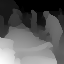

In [30]:
transforms.ToPILImage()(test_images[0].permute(2,0,1))

In [20]:
# test_images = batch_generator_external_images(test_images)
batch_size = 30
testloader = DataLoader(test_images,batch_size,shuffle=False)

In [21]:
test_latents = []
for i,x in enumerate(tqdm(testloader)):
  data_input, target = preprocess_fn(x)
  with torch.no_grad():
        # print(i*batch_size)
        activations = ema_vae.encoder.forward(data_input)
        px_z, stats = ema_vae.decoder.forward(activations, get_latents=True)
        #recons = ema_vae.decoder.out_net.sample(px_z)
        batch_latent = []
        for i in range(num_latents):
            batch_latent.append(stats[i]['z'].cpu().numpy().reshape(len(data_input),-1))
        test_latents.append(np.hstack(batch_latent))
        #stats_all.append(stats)
        #imshow(imgrid(recons, cols=batch_size,pad=20))
        #imshow(imgrid(test_images[i*batch_size : (i+1)*batch_size], cols=batch_size,pad=20))
test_latents = np.concatenate(test_latents)

100%|██████████| 33/33 [00:20<00:00,  1.61it/s]


In [22]:
pred_latents = np.load('data/predicted_features/subj{:02d}/nsd_vdvae_nsdgeneral_pred_sub{}_alpha{}k.npy'.format(sub,sub,alpha))
ref_latent = stats

In [23]:
# Transform latents from flattened representation to hierarchical
def latent_transformation(latents, ref):
  layer_dims = np.array([2**4,2**4,2**8,2**8,2**8,2**8,2**10,2**10,2**10,2**10,2**10,2**10,2**10,2**10,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14,2**14])
  transformed_latents = []
  for i in range(num_latents):
    t_lat = latents[:,layer_dims[:i].sum():layer_dims[:i+1].sum()]
    #std_norm_test_latent = (t_lat - np.mean(t_lat,axis=0)) / np.std(t_lat,axis=0)
    #renorm_test_latent = std_norm_test_latent * np.std(kamitani_latents[i][num_test:].reshape(num_train,-1),axis=0) + np.mean(kamitani_latents[i][num_test:].reshape(num_train,-1),axis=0)
    c,h,w=ref[i]['z'].shape[1:]
    transformed_latents.append(t_lat.reshape(len(latents),c,h,w))
  return transformed_latents

def sample_from_hier_latents(latents,sample_ids):
  sample_ids = [id for id in sample_ids if id<len(latents[0])]
  layers_num=len(latents)
  sample_latents = []
  for i in range(layers_num):
    sample_latents.append(torch.tensor(latents[i][sample_ids]).float().cuda())
  return sample_latents

In [24]:
num_test = len(test_images)
num_test

982

In [25]:
idx = range(num_test)
input_latent = latent_transformation(pred_latents[idx],ref_latent)

In [26]:
for ndx in tqdm(range(int(np.ceil(num_test/batch_size)))):
  # print(ndx*batch_size)
  samp = sample_from_hier_latents(input_latent,range(ndx*batch_size,(ndx+1)*batch_size))
  px_z = ema_vae.decoder.forward_manual_latents(len(samp[0]), samp, t=None)
  sample_from_latent = ema_vae.decoder.out_net.sample(px_z)
  upsampled_images = []
  for idx in range(len(sample_from_latent)):
      im = sample_from_latent[idx]
      im = Image.fromarray(im)
      im = im.resize((512,512),resample=3)
      im.save('/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae/subj{:02d}/{}.png'.format(sub,ndx*batch_size+idx))

100%|██████████| 33/33 [00:22<00:00,  1.47it/s]
